In [2]:
"""
Notebook : Extraction et Analyse des Tokens WavTokenizer
Objectif : mesurer l'entropie, histogrammes et token dominant
afin de représenter le paysage sonore et coupler
avec les données météo (affichage mensuel et annuel).
"""
# 1. Imports et configuration
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from datetime import timedelta
from datetime import datetime
from collections import defaultdict
import seaborn as sns
import re # Importation de re pour les expressions régulières
import tqdm # Importation de tqdm pour la barre de progression
from scipy.optimize import curve_fit # Import curve_fit
from scipy.stats import skew, kurtosis
from decoder.pretrained import WavTokenizer

# Montage de Google Drive
#drive.mount('/content/drive')
#!unzip -q "/content/drive/MyDrive/Exctraction+token/test/result_tokens.zip" -d "/content/drive/MyDrive/Exctraction+token/test/"

In [3]:
# Répertoires et extensions
base_path = "/home/m1projetisi"
chemin_txt = os.path.join(base_path, "WavTokenizer/files_list.txt")
token_dir = os.path.join(base_path, "WavTokenizer/result_tokens_v9")
TOKENS_EXT = '.pt'

# Paramètres d'analysis
BIN_COUNT    = 4096      # Utilise 4096 pour le calcul de l'histogramme complet
WINDOW_SIZE  = 1024    # taille fenêtre glissante pour entropie
STEP         = 512     # décalage de la fenêtre

# 2. Fonctions utilitaires
def compute_entropy(tokens, window=WINDOW_SIZE, step=STEP):
    tokens = np.asarray(tokens)

    if len(tokens) < window:
        return np.array([])

    shape = ((len(tokens) - window) // step + 1, window)
    strides = (tokens.strides[0] * step, tokens.strides[0])
    windows = np.lib.stride_tricks.as_strided(tokens, shape=shape, strides=strides)

    # Preallocate output
    result = np.empty(windows.shape[0], dtype=np.float32)

    for i, w in enumerate(windows):
        counts = np.bincount(w, minlength=4096)
        probs = counts / counts.sum()
        probs = probs[probs > 0]
        result[i] = entropy(probs, base=2)

    return result

def hist_and_dominant(tokens, bins=BIN_COUNT):
    """
    Calcule l'histogramme normalisé et les tokens dominants non-nuls (par fréquence décroissante).
    Retourne :
    - histogramme normalisé (array de 4096 floats)
    - liste des tokens dominants non-nuls (ex: [138, 412, 58, ...])
    """
    tokens = np.array(tokens)

    if tokens.size == 0:
        return np.zeros(bins), []

    hist = np.bincount(tokens, minlength=bins)
    hist_norm = hist / hist.sum() if hist.sum() > 0 else hist

    # Conserve uniquement les tokens dont la fréquence est > 0
    nonzero_indices = np.nonzero(hist)[0]
    # Trie par fréquence décroissante parmi ceux qui apparaissent
    top_tokens = nonzero_indices[np.argsort(hist[nonzero_indices])[::-1]]

    return hist_norm, top_tokens

def extract_timestamp_from_filename(filename):
    # Updated regex to match the file name format S4A09154_20190218_163000.flac
    match = re.search(r"_(\d{8})_(\d{6})\.flac", filename)
    if match:
        date_str, time_str = match.groups()
        timestamp_str = f"{date_str}{time_str}"
        return pd.to_datetime(timestamp_str, format="%Y%m%d%H%M%S", errors='coerce')
    return pd.NaT

#  Fonction d'arrondi vers le quart d'heure le plus proche
def arrondir_vers_quart_heure_le_plus_proche(dt):
    minute = (dt.minute // 15) * 15
    dt_bas = dt.replace(minute=minute, second=0, microsecond=0)
    dt_haut = dt_bas + timedelta(minutes=15)
    return dt_bas if abs((dt - dt_bas).total_seconds()) <= abs((dt - dt_haut).total_seconds()) else dt_haut

# Fonction pour traiter les DataFrames météo
def process_meteo_df(df, rename_dict):
    df = df.copy()
    # Check if the first row contains the actual headers
    if 'Date Heure GMT -0300' in df.iloc[0].values:
         df.columns = df.iloc[0].astype(str).str.strip()
         df = df[1:]
    df.columns = df.columns.str.strip()
    df.rename(columns=rename_dict, inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce') # Gère les erreurs potentielles dans la conversion de datetime
    df = df.dropna(subset=['datetime']) # Supprime les lignes où la conversion datetime a échoué
    df["rounded_datetime"] = df["datetime"].apply(arrondir_vers_quart_heure_le_plus_proche)
    df = df.drop(columns=["datetime"])
    # Convert relevant columns to numeric, coercing errors to NaN
    for col in rename_dict.values():
        if col != 'datetime':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


# 3. Data Processing

# Load and process meteo data
ground_lux_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_ground_lux_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp. °C": "ground_temp",
        "Intensité, lux": "ground_lux"
    }
)

canopy_lux_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_canopy_lux_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp. °C": "canopy_temp",
        "Intensité lux": "canopy_lux"
    }
)

ground_rh_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_ground_rh_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp °C": "ground_temp",
        "HR %": "ground_rh",
        "PtRosée °C": "ground_ptrose"
    }
)

canopy_rh_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_canopy_rh_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp °C": "canopy_temp",
        "HR %": "canopy_rh",
        "PtRosée °C": "canopy_ptrose"
    }
)

# Combine meteo data into a single dictionary
meteo_par_datetime = defaultdict(dict)

def add_to_meteo_dict(df):
    for _, row in df.iterrows():
        dt = row["rounded_datetime"]
        for col in df.columns:
            if col != "rounded_datetime":
                meteo_par_datetime[dt][col] = row[col]

add_to_meteo_dict(ground_lux_clean)
add_to_meteo_dict(canopy_lux_clean)
add_to_meteo_dict(ground_rh_clean)
add_to_meteo_dict(canopy_rh_clean)


# Process audio data and integrate with meteo data
fichiers_par_date = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Read audio files paths from the list
wav_paths = []
if os.path.exists(chemin_txt):
    with open(chemin_txt, "r", encoding="utf-8") as f:
        wav_paths = [line.strip() for line in f if line.strip().lower().endswith(".flac")]
else:
    print(f"Attention : Liste de fichiers non trouvée à {chemin_txt}. Traitement audio ignoré.")


def ensure_flat_numpy(tokens):
    try:
        if isinstance(tokens, torch.Tensor):
            return tokens.numpy().flatten()
        elif isinstance(tokens, np.ndarray):
            return tokens.flatten()
        elif isinstance(tokens, (list, tuple)):
            return np.array(tokens).flatten()
        else:
            return None
    except Exception as e:
        print(f"Erreur lors de la conversion des tokens en numpy aplati : {e}")
        return None

# Process each audio file
for path in tqdm.tqdm(wav_paths, desc="Traitement des fichiers audio"):
    try:
        filename = os.path.basename(path)
        dt = extract_timestamp_from_filename(filename)

        if pd.isna(dt):
            print(f"Attention : Impossible d'extraire l'horodatage valide du nom de fichier : {filename}. Ignoré.")
            continue

        rounded_dt = arrondir_vers_quart_heure_le_plus_proche(dt)

        annee = dt.year
        mois = dt.month
        jour = dt.day

        nom_sans_ext = os.path.splitext(filename)[0]
        token_path = os.path.join(token_dir, nom_sans_ext + TOKENS_EXT)

        tokens = None
        diversite = None
        entropie_moy = None
        histogramme = None
        token_dom = None

        # Check if the token file exists and load with torch
        if os.path.exists(token_path):
            # print(f"--- Debug Main Loop: Token file exists for {filename}") # Debug print
            try:
                loaded_tokens = torch.load(token_path)
                # print(f"--- Debug Main Loop: Loaded token data type for {filename}: {type(loaded_tokens)}") # Debug print
                # print(f"--- Debug Main Loop: Loaded token data content (first 10) for {filename}: {loaded_tokens if not isinstance(loaded_tokens, (torch.Tensor, np.ndarray)) else (loaded_tokens.flatten()[:10] if hasattr(loaded_tokens, 'flatten') else loaded_tokens[:10])}") # Debug print

                # Check if the loaded object is a dictionary and contains 'tokens'
                if isinstance(loaded_tokens, dict) and 'tokens' in loaded_tokens:
                    tokens = loaded_tokens['tokens']
                    # print(f"--- Debug Main Loop: Extracted 'tokens' from dict for {filename}. Type: {type(tokens)}") # Debug print
                else:
                    tokens = loaded_tokens # Assume the loaded object is the tokens directly
                    # print(f"--- Debug Main Loop: Assuming loaded object is tokens directly for {filename}. Type: {type(tokens)}") # Debug print

                # Ensure tokens are a numpy array for processing and flatten it
                tokens = ensure_flat_numpy(tokens)

                if tokens is not None and tokens.size > 0:
                    # print(f"--- Debug Main Loop: Processing non-empty tokens for {filename}. Size: {tokens.size}. Shape: {tokens.shape}") # Debug print before calling functions
                    # Calculate diversity, entropy, histogram, and dominant token
                    entropy_series = compute_entropy(tokens) # This now receives a 1D array
                    # print(f"--- Debug Main Loop: Entropy series size for {filename}: {entropy_series.size}") # Debug print
                    entropie_moy = np.mean(entropy_series) if entropy_series.size > 0 else None # Changed back to mean
                    histogramme, top_tokens = hist_and_dominant(tokens)

                else:
                    print(f" Attention : Les données de token sont vides ou n'ont pas pu être traitées pour {token_path}. Tokens après chargement/conversion/aplatissement : {tokens}") # Modified warning
                    tokens = None
                    diversite = None
                    entropie_moy = None
                    histogramme = None
                    token_dom = None


            except Exception as e:
                print(f" Erreur de chargement ou de traitement pour {token_path} : {e}")
                tokens = None
                diversite = None
                entropie_moy = None
                histogramme = None
                token_dom = None
        else:
            # print(f"--- Debug Main Loop: Token file not found for {token_path}") # Debug print if token file is missing
            pass


        # Add data to the dictionary structured by date
        fichiers_par_date[annee][mois][jour].append({
            "fichier": nom_sans_ext,
            "heure": dt.time(),
            "datetime_arrondi": rounded_dt,
            "meteo": meteo_par_datetime.get(rounded_dt, {}),
            "token": tokens,
            "entropie_moy": entropie_moy,
            "histogramme": histogramme, # This is the 4096-bin normalized histogram
            "token_dominants": top_tokens
        })

    except Exception as e:
        print(f" Erreur avec le fichier : {path} → {e}")

Traitement des fichiers audio: 100%|██████████| 29580/29580 [00:50<00:00, 586.50it/s]


In [4]:
CONFIG = "WavTokenizer/result/train/train_flac_10sslices_rand3s/lightning_logs/version_9/config.yaml"
MODEL_PATH = "WavTokenizer/result/train/train_flac_10sslices_rand3s/lightning_logs/version_9/checkpoints/last.ckpt"
device = torch.device('cpu')
model = WavTokenizer.from_pretrained0802(CONFIG, MODEL_PATH)

Fitting PCA on shape: (13392000, 512)


Extracting daily vectors: 100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Running t-SNE on shape: (31, 50)


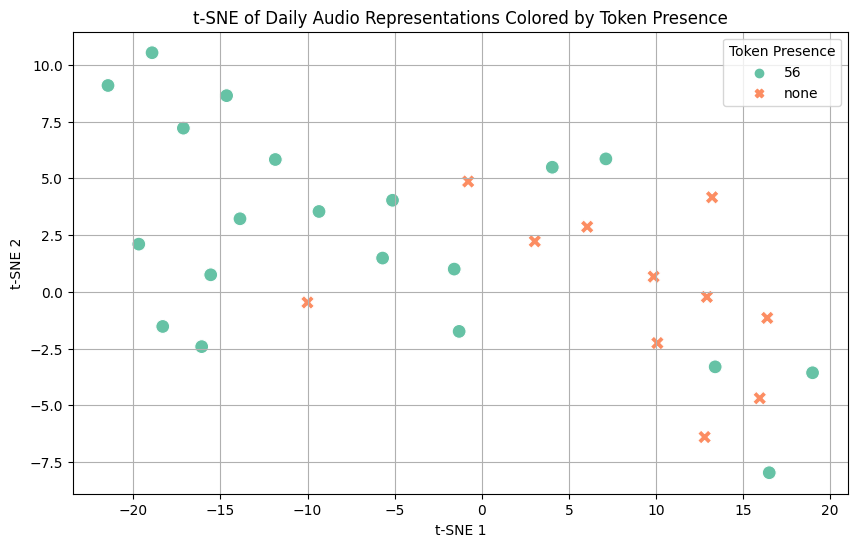

In [48]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Step 1: Extract features for one day (concatenated) ---
def extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device):
    fichiers = fichiers_par_date.get(annee, {}).get(mois, {}).get(jour, [])
    all_tokens = []

    for fichier in fichiers:
        tokens = torch.tensor(fichier["token"], dtype=torch.long).view(1, 1, -1).to(device)  # [1,1,T]
        with torch.no_grad():
            feats = model.codes_to_features(tokens)  # [1, 512, T]
            feats = feats.squeeze(0).permute(1, 0)  # [T, 512]
            all_tokens.append(feats.cpu().numpy())

    if len(all_tokens) == 0:
        return None  # No data for this day

    return np.concatenate(all_tokens, axis=0)  # [N_tokens, 512]

# --- Step 2: Collect tokens from all days for PCA fitting ---
def collect_all_tokens(fichiers_par_date, annee, mois, jours, model, device):
    all_tokens = []
    for jour in tqdm(jours, desc="Collecting all tokens for PCA"):
        day_tokens = extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device)
        if day_tokens is not None:
            all_tokens.append(day_tokens)
    return np.vstack(all_tokens)  # [Total_tokens, 512]

# --- Step 3: Create daily vectors by PCA reduction + averaging ---
def get_daily_vectors(fichiers_par_date, annee, mois, jours, model, device, pca):
    daily_vectors = []
    valid_days = []

    for jour in tqdm(jours, desc="Extracting daily vectors"):
        day_tokens = extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device)
        if day_tokens is None:
            continue
        day_pca = pca.transform(day_tokens)  # [N_tokens, 50]
        day_vec = day_pca.mean(axis=0)  # [50]
        daily_vectors.append(day_vec)
        valid_days.append(jour)

    return np.vstack(daily_vectors), valid_days  # [N_days, 50], [jours]

# --- Step 4: Run PCA + t-SNE pipeline ---
def run_tsne_on_days(fichiers_par_date, annee, mois, model, device, pca_dim=50, tsne_dim=2):
    jours = sorted(fichiers_par_date.get(annee, {}).get(mois, {}).keys())

    # Fit PCA on all tokens across all days
    all_tokens = collect_all_tokens(fichiers_par_date, annee, mois, jours, model, device)
    print(f"Fitting PCA on shape: {all_tokens.shape}")
    pca = PCA(n_components=pca_dim, random_state=42)
    pca.fit(all_tokens)

    # Reduce & average per day
    daily_vectors, valid_days = get_daily_vectors(fichiers_par_date, annee, mois, jours, model, device, pca)

    # Run t-SNE on the daily vectors
    print(f"Running t-SNE on shape: {daily_vectors.shape}")
    tsne = TSNE(n_components=tsne_dim, perplexity=10, random_state=42)
    tsne_points = tsne.fit_transform(daily_vectors)

    return tsne_points, valid_days

import seaborn as sns
import matplotlib.pyplot as plt

def get_token_presence_labels(fichiers_par_date, annee, mois, valid_days, target_tokens):
    labels = []

    for jour in valid_days:
        fichiers = fichiers_par_date.get(annee, {}).get(mois, {}).get(jour, [])
        tokens_in_day = []

        for fichier in fichiers:
            tokens_in_day.extend(fichier["token"])

        tokens_in_day = set(tokens_in_day)
        found = [str(t) for t in target_tokens if t in tokens_in_day]

        if len(found) == 0:
            labels.append("none")
        elif len(found) == 1:
            labels.append(found[0])
        else:
            labels.append("both")

    return labels

year = 2019
month = 3
# Step 1: Compute t-SNE (if not already done)
tsne_points, valid_days = run_tsne_on_days(fichiers_par_date, year, month, model, device)

# Step 2: Create labels for token presence
token_labels = get_token_presence_labels(fichiers_par_date, year, month, valid_days, target_tokens=[56])

# Step 3: Create DataFrame for plotting
import pandas as pd

df_plot = pd.DataFrame({
    "x": tsne_points[:, 0],
    "y": tsne_points[:, 1],
    "day": valid_days,
    "label": token_labels
})

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x="x", y="y", hue="label", style="label", s=100, palette="Set2")
plt.title("t-SNE of Daily Audio Representations Colored by Token Presence")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Token Presence")
plt.grid(True)
plt.show()

In [11]:
def check_token_presence_march_with_year_stats(fichiers_par_date, target_tokens, m):
    found = {token: [] for token in target_tokens}
    days_march = {token: set() for token in target_tokens}
    days_year = {token: set() for token in target_tokens}

    total_files_march = 0
    total_files_year = 0

    for annee in fichiers_par_date:
        for mois in fichiers_par_date[annee]:
            for jour in fichiers_par_date[annee][mois]:
                for fichier in fichiers_par_date[annee][mois][jour]:
                    token_list = [int(t) for t in fichier.get("token", [])]  # <-- force int
                    if mois == m:
                        total_files_march += 1
                    total_files_year += 1

                    for token in target_tokens:
                        if token in token_list:
                            found[token].append({
                                "annee": annee,
                                "mois": mois,
                                "jour": jour,
                                "filename": fichier.get("filename", "unknown")
                            })
                            days_year[token].add((annee, mois, jour))
                            if mois == m:
                                days_march[token].add((annee, mois, jour))

    return found, days_march, days_year, total_files_march, total_files_year

target_tokens = [98, 490]
results, days_march, days_year, total_march, total_year = check_token_presence_march_with_year_stats(fichiers_par_date, target_tokens, 3)

for token, matches in results.items():
    count_files = len([m for m in matches if m["mois"] == 3])
    count_days_march = len(days_march[token])
    count_days_year = len(days_year[token])

    print(f"\n Token {token} statistics:")
    print(f"  - Files with token in March: {count_files} / {total_march} ({count_files / total_march:.2%})")
    print(f"  - Files with token in Year: {len(matches)} / {total_year} ({len(matches) / total_year:.2%})")
    print(f"  - Days with token in March: {count_days_march}")
    print(f"  - Days with token in Year: {count_days_year}")


 Token 98 statistics:
  - Files with token in March: 67 / 2976 (2.25%)
  - Files with token in Year: 1550 / 29580 (5.24%)
  - Days with token in March: 24
  - Days with token in Year: 239

 Token 539 statistics:
  - Files with token in March: 960 / 2976 (32.26%)
  - Files with token in Year: 5194 / 29580 (17.56%)
  - Days with token in March: 31
  - Days with token in Year: 306

 Token 490 statistics:
  - Files with token in March: 21 / 2976 (0.71%)
  - Files with token in Year: 292 / 29580 (0.99%)
  - Days with token in March: 13
  - Days with token in Year: 160

 Token 71 statistics:
  - Files with token in March: 1002 / 2976 (33.67%)
  - Files with token in Year: 10935 / 29580 (36.97%)
  - Days with token in March: 31
  - Days with token in Year: 313

 Token 31 statistics:
  - Files with token in March: 440 / 2976 (14.78%)
  - Files with token in Year: 4709 / 29580 (15.92%)
  - Days with token in March: 31
  - Days with token in Year: 299

 Token 63 statistics:
  - Files with token

In [36]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Extract features for one day ---
def extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device):
    fichiers = fichiers_par_date.get(annee, {}).get(mois, {}).get(jour, [])
    all_tokens = []

    for fichier in fichiers:
        tokens = torch.tensor(fichier["token"], dtype=torch.long).view(1, 1, -1).to(device)
        with torch.no_grad():
            feats = model.codes_to_features(tokens)
            feats = feats.squeeze(0).permute(1, 0)  # [T, 512]
            all_tokens.append(feats.cpu().numpy())

    if len(all_tokens) == 0:
        return None

    return np.concatenate(all_tokens, axis=0)

# --- Step 2: Collect all token features for PCA ---
def collect_all_tokens_year(fichiers_par_date, annee, model, device):
    all_tokens = []
    for mois in sorted(fichiers_par_date.get(annee, {})):
        for jour in sorted(fichiers_par_date[annee][mois]):
            day_tokens = extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device)
            if day_tokens is not None:
                all_tokens.append(day_tokens)
    return np.vstack(all_tokens)

# --- Step 3: Daily vectors by PCA reduction and averaging ---
def get_daily_vectors_year(fichiers_par_date, annee, model, device, pca):
    daily_vectors = []
    valid_dates = []

    for mois in sorted(fichiers_par_date.get(annee, {})):
        for jour in sorted(fichiers_par_date[annee][mois]):
            day_tokens = extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device)
            if day_tokens is None:
                continue
            day_pca = pca.transform(day_tokens)
            daily_vec = day_pca.mean(axis=0)
            daily_vectors.append(daily_vec)
            valid_dates.append((mois, jour))

    return np.vstack(daily_vectors), valid_dates

# --- Step 4: Run full t-SNE pipeline ---
def run_tsne_year(fichiers_par_date, annee, model, device, pca_dim=50, tsne_dim=2):
    # Collect all token vectors
    all_tokens = collect_all_tokens_year(fichiers_par_date, annee, model, device)
    print(f"PCA fitting on shape: {all_tokens.shape}")
    pca = PCA(n_components=pca_dim)
    pca.fit(all_tokens)

    # Reduce each day
    daily_vectors, valid_dates = get_daily_vectors_year(fichiers_par_date, annee, model, device, pca)
    print(f"Running t-SNE on shape: {daily_vectors.shape}")
    tsne = TSNE(n_components=tsne_dim, random_state=42)
    tsne_points = tsne.fit_transform(daily_vectors)

    return tsne_points, valid_dates

# --- Step 5: Label presence of tokens per day ---
def get_token_presence_labels_year(fichiers_par_date, annee, valid_dates, target_tokens):
    labels = []

    for annee, mois, jour in valid_dates:
        fichiers = fichiers_par_date.get(annee, {}).get(mois, {}).get(jour, [])
        tokens_in_day = []
        for fichier in fichiers:
            tokens_in_day.extend(fichier.get("token", []))
        tokens_in_day = set(tokens_in_day)
        found = [str(t) for t in target_tokens if t in tokens_in_day]

        if len(found) == 0:
            labels.append("none")
        elif len(found) == 1:
            labels.append(found[0])
        else:
            labels.append("multiple")

    return labels

# --- Step 6: Visualize ---
def plot_tsne_year(tsne_points, valid_dates, labels):
    df_plot = pd.DataFrame({
        "x": tsne_points[:, 0],
        "y": tsne_points[:, 1],
        "date": [f"{mois:02d}-{jour:02d}" for _, mois, jour in valid_dates],
        "label": labels
    })

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_plot, x="x", y="y", hue="label", style="label", s=100, palette="Set2")
    plt.title("t-SNE of Daily Audio Representations (Full Year)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title="Token Presence")
    plt.grid(True)
    plt.show()


In [52]:
# If IPCA already done: open file (
# To open and load embeddings/valid dates
with open("embedding_and_dates.pkl", "rb") as f:
    data = pickle.load(f)

embedding = data["embedding"]
valid_dates = data["valid_dates"]

In [ ]:
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm
from sklearn.manifold import TSNE

# Don't do if already done and files loaded, takes a long time
def fit_ipca_year(fichiers_par_date, annee, model, device, n_components=50):
    ipca = IncrementalPCA(n_components=n_components, batch_size=5000)
    mois_list = sorted(fichiers_par_date.get(annee, {}))
    for mois in tqdm(mois_list, desc="PCA fitting - Months"):
        jours_list = sorted(fichiers_par_date[annee][mois])
        for jour in tqdm(jours_list, desc=f"PCA fitting - Mois {mois}", leave=False):
            tokens = extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device)
            if tokens is not None:
                ipca.partial_fit(tokens)
    return ipca

def get_daily_vectors_year_ipca(fichiers_par_date, annee, model, device, ipca):
    daily_vectors = []
    valid_dates = []
    mois_list = sorted(fichiers_par_date.get(annee, {}))
    for mois in tqdm(mois_list, desc="Extract daily vectors - Months"):
        jours_list = sorted(fichiers_par_date[annee][mois])
        for jour in tqdm(jours_list, desc=f"Extract daily vectors - Mois {mois}", leave=False):
            tokens = extract_features_for_day(fichiers_par_date, annee, mois, jour, model, device)
            if tokens is not None:
                pca_tokens = ipca.transform(tokens)
                day_vector = np.mean(pca_tokens, axis=0)
                daily_vectors.append(day_vector)
                valid_dates.append((annee, mois, jour))
    return np.array(daily_vectors), valid_dates

ipca = fit_ipca_year(fichiers_par_date, 2019, model, device, n_components=50)
daily_vectors, valid_dates = get_daily_vectors_year_ipca(fichiers_par_date, 2019, model, device, ipca)

tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(daily_vectors)

import pickle

# To save embeddings/valid dates
with open("embedding_and_dates.pkl", "wb") as f:
    pickle.dump({
        "embedding": embedding,
        "valid_dates": valid_dates
    }, f)
    
# Plot in new cell
#plot_tsne_year(embedding, valid_dates, token_labels)

PCA fitting - Mois 11:   0%|          | 0/29 [00:00<?, ?it/s]

In [46]:
token_labels = get_token_presence_labels_year(fichiers_par_date, 2019, valid_dates, target_tokens=[24])
print(token_labels)

['none', '56', '56', 'none', '56', 'none', 'none', '56', 'none', 'none', '56', '56', '56', '56', 'none', 'none', '56', 'none', 'none', '56', '56', '56', '56', '56', '56', 'none', 'none', 'none', '56', '56', '56', 'none', '56', 'none', '56', 'none', '56', '56', 'none', '56', '56', '56', 'none', '56', 'none', 'none', '56', '56', '56', '56', '56', '56', '56', '56', '56', 'none', 'none', '56', 'none', 'none', '56', '56', '56', '56', '56', '56', '56', '56', '56', 'none', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', 'none', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', 'none', '56', '56', 'none', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', 'none', '56', '56', '56', '56', '56', '56', 'none', 'none', '56', '56', 'none', 'none', '56', '56', '56', 'none', '56', '56', 'none', '56', '56', 'none', '56', 'none', '56', '56', 'none', '56', '56', 'none', '56', '56', '56', '56', '56', '56', '56', '56', 'none', '56', '56', '56', '56', '56', '

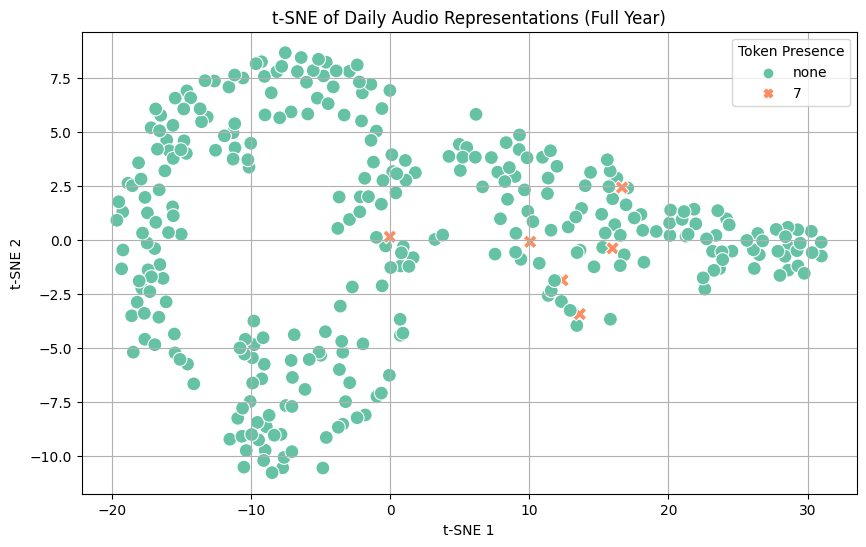

In [59]:
token_labels = get_token_presence_labels_year(fichiers_par_date, 2019, valid_dates, target_tokens=[7]) #test tokens
plot_tsne_year(embedding, valid_dates, token_labels)